In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
#import matplotlob

2024-05-06 08:51:27.152007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 08:51:27.152130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 08:51:27.246773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

Below, we get the train and test images 90 vs 10

In [16]:
x_train=np.zeros((270,220,220,3), np.uint8)
for i in range(1,91):
    img=cv2.imread(f"/kaggle/input/ball-dataset/train_data/train_data/images/train/{i}.png")
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    with open(f"/kaggle/input/ball-dataset/train_data/train_data/labels/train/{i}.txt", 'r') as file:
        fc = file.readline()
    a=fc.split(" ")
    a[4]=a[4][:-1]
    #print(a)
    x=float(a[1])
    y=float(a[2])
    w=float(a[3])
    h=float(a[4])

    
    # #img_2=img[int(780*float(a[1])):int(780*float(a[2])), int(1820*float(a[3])):int(1820*float(a[4])), : ]
    img_2=img[int(780*(y-h/2)):int(780*(y+h/2)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
    resized_image = cv2.resize(img_2, (220,220))
    if i<=15:
        #half_img=img[int(780*(y-h)):int(780*(y)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
        half_img=img[int(780*(y-h)):int(780*(y)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
    elif i<=30:
        try:
            half_img=img[int(780*(y)):int(780*(y+h)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
        except:
            half_img=img[int(780*(y-h)):int(780*(y)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
            half_img = cv2.flip(half_img, 0)
            
    elif i<=45:
        half_img=img[int(780*(y-h/2)):int(780*(y+h/2)),int(1820*(x-w/4)):int(1820*(x+3*w/4)), : ]
    elif i<=60:
        half_img=img[int(780*(y-h/4)):int(780*(y+3*h/4)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
    
    
    elif i<=75:
        half_img=img[int(780*(y-h/2)):int(780*(y+h/2)),int(1820*(x-3*w/4)):int(1820*(x+w/4)), : ]
    elif i<=90:
        half_img=img[int(780*(y-3*h/4)):int(780*(y+h/4)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
    resized_half= cv2.resize(half_img, (220,220))
    #resized_half= cv2.resize(half_img, (220,220))
    #imshow(resized_half)
    #plt.show()
    #print(resized_half.shape)
    
    # cv2.imshow('img_2', img_2)
    # cv2.waitKey(500)
    x_train[i-1]=resized_image
    x_train[i-1+90]=img[:220,:220,:]
    x_train[i-1+180]= resized_half

x_train=x_train/255
print(x_train.shape)

(270, 220, 220, 3)


In [36]:
x_train.shape

(270, 220, 220, 3)

In [4]:
Y_train=np.ones((270,1), np.uint8)
Y_train[90:270]=np.zeros((180,1), np.uint8)

Below test cropped

In [5]:
x_test_cropped=np.zeros((20,220,220,3), np.uint8)
for i in range(91,101):
    img=cv2.imread(f"/kaggle/input/ball-dataset/train_data/train_data/images/test/{i}.png")

    with open(f"/kaggle/input/ball-dataset/train_data/train_data/labels/test/{i}.txt", 'r') as file:
        fc = file.readline()
    a=fc.split(" ")
    a[4]=a[4][:-1]
    #print(a)
    x=float(a[1])
    y=float(a[2])
    w=float(a[3])
    h=float(a[4])

    
    # #img_2=img[int(780*float(a[1])):int(780*float(a[2])), int(1820*float(a[3])):int(1820*float(a[4])), : ]
    img_2=img[int(780*(y-h/2)):int(780*(y+h/2)),int(1820*(x-w/2)):int(1820*(x+w/2)), : ]
    resized_image = cv2.resize(img_2, (220,220))
    #print(resized_image.shape)
    # cv2.imshow('img_2', img_2)
    # cv2.waitKey(500)
    x_test_cropped[i-91]=resized_image
    #x_test_cropped[i-1]=resized_image
    x_test_cropped[i-91+10]=img[:220,:220,:]
x_test_cropped=x_test_cropped/255
print(x_test_cropped.shape)

(20, 220, 220, 3)


In [6]:
Y_test=np.ones((20,1), np.uint8)
Y_test[10:20]=np.zeros((10,1), np.uint8)

In [53]:
Y_test

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)

In [7]:
# Define the CNN model
def create_model():
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(220, 220, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # Dense (fully connected) layers
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


# Create an instance of the model
model = create_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,930,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,171,713 (31.17 MB)

 Trainable params: 8,171,713 (31.17 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(x_train, Y_train, epochs=10)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 5.0769e-05
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.5377e-07
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 7.3038e-11
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 2.2647e-12
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 8.6504e-13
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 2.1755e-12
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.4848e-12
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.7821e-12
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.8325e-12
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.8258e-12


In [9]:
model.evaluate(x_test_cropped,Y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 6.5151e-05


W0000 00:00:1714985543.698299     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[6.515132554341108e-05, 1.0]

In [ ]:
def results(numb):
  predicted=[]
  num_images = numb
  for i in range(numb):
    k=X_test[i]
    k=k.reshape((-1,) + k.shape[0:])
    p=model.predict(k)
    p=np.array(np.round(p[0]*255),np.uint8)
    predicted.append(p)
  predicted=np.array(predicted, np.uint8)
  return predicted

In [10]:
img_t=cv2.imread(f"/kaggle/input/ball-dataset/train_data/train_data/images/test/{91}.png")
img_t = cv2.cvtColor(img_t, cv2.COLOR_RGB2BGR)
img_t2=img_t[:220,:220,:]
k=img_t2/255
k=x_test_cropped[9]
k=k.reshape((-1,) + k.shape[0:])
p=model.predict(k)
print(p[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1.0


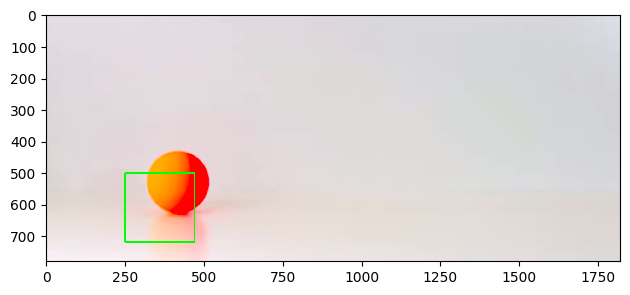

In [19]:
for k in range(count):
    img_t=cv2.imread(f"/kaggle/input/ball-dataset/train_data/train_data/images/test/{92+k}.png")
    img_t = cv2.cvtColor(img_t, cv2.COLOR_RGB2BGR)
    img_t2=cv2.rectangle(img_t, (int(pred[k][2]),int(pred[k][1])), (int(pred[k][2])+220,int(pred[k][1])+220), (0, 255, 0), 4)
    imshow(img_t2)
    plt.show()
    #print(pred)

In [18]:
count=1
pred=np.zeros((count,3), np.float64)
#pred=[0,0,0]
for m in range(count):
    img_t=cv2.imread(f"/kaggle/input/ball-dataset/train_data/train_data/images/test/{92+m}.png")
    img_t = cv2.cvtColor(img_t, cv2.COLOR_RGB2BGR)
    #pred=[0,0,0]
    for i in range(0,560, 50):
        for j in range(0,1600, 50):
            img_t2=img_t[i:220+i,j:220+j,:]
            k=img_t2/255
            k=k.reshape((-1,) + k.shape[0:])
            p=model.predict(k)
            if p[0][0]>=pred[m][0]:
                pred[m][0]=p[0][0]
                pred[m][1]=i
                pred[m][2]=j
                print(pred)
#print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[3.90141234e-13 0.00000000e+00 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[4.27878734e-13 0.00000000e+00 5.00000000e+01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[5.09001261e-13 0.00000000e+00 5.00000000e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[5.53251672e-13 0.00000000e+00 7.00000000e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[6.04546144e-13 0.00000000e+00 7.50000000e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[6.3672559e-13 0.0000000e+00 8.0000000e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[6.47428996e-13 0.000000